In [97]:
%%time
import numpy as np
import pandas as pd
import seaborn as sns     
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline
from geopy.distance import great_circle
import folium                                        # map visualizations
from folium.plugins import HeatMap
import dask
import dask.dataframe as dd
import dask.multiprocessing
from dask.distributed import Client,progress 
client=Client()
#dask.config.set({"distributed.comm.timeouts.connect": "50s"})
client

Wall time: 3.08 s


Client Scheduler: tcp://127.0.0.1:56780 Dashboard: http://127.0.0.1:56779/status,Cluster Workers: 4 Cores: 8 Memory: 8.43 GB


#### Extracting zipfile

In [4]:
# import zipfile
# with zipfile.ZipFile("archive (1).zip") as zip_ref:
#     zip_ref.extractall("taxidata")

#### Set columns to most suitable type to optimize for memory usage and speed-up the loading and select the columns (names) that you truly need for analysis

In [5]:
%%time
# Set columns to most suitable type to optimize for memory usage and speed-up the loading
data_types = {'vendor_id' : 'str',
               'fare_amount'      : 'float32',
               'pickup_datetime'  : 'str', 
               'dropoff_datetime' : 'str',
               'passenger_count' :'float',
               #'trip_distance':   'float',
               'pickup_longitude' : 'float32',
               'pickup_latitude'  : 'float32',
               #'store_and_fwd_flag' : 'str',
               'dropoff_longitude': 'float32',
               'dropoff_latitude' : 'float32',
               'payment_type' :   'str',
               'tip_amount' :'float',
        
             }

#select the columns (names) that you truly need for analysis
data_cols = list(data_types.keys())

Wall time: 0 ns


#### Reading csv file,creating dask data frame and understanding data

In [6]:
%%time
taxi_data= dd.read_csv("nyc_taxi_data_2014.csv",sep=',', dtype=data_types,engine='python')
taxi_data.head()

Wall time: 9.5 s


,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,CMT,2014-01-09 20:45:25,2014-01-09 20:52:31,1.0,0.7,-73.994766,40.736828,1,N,-73.982224,40.731789,CRD,6.5,0.5,0.5,1.40,0.0,8.90
1,CMT,2014-01-09 20:46:12,2014-01-09 20:55:12,1.0,1.4,-73.982391,40.773380,1,N,-73.960449,40.763996,CRD,8.5,0.5,0.5,1.90,0.0,11.40
2,CMT,2014-01-09 20:44:47,2014-01-09 20:59:46,2.0,2.3,-73.988571,40.739407,1,N,-73.986626,40.765217,CRD,11.5,0.5,0.5,1.50,0.0,14.00
3,CMT,2014-01-09 20:44:57,2014-01-09 20:51:40,1.0,1.7,-73.960213,40.770466,1,N,-73.979866,40.777050,CRD,7.5,0.5,0.5,1.70,0.0,10.20
4,CMT,2014-01-09 20:47:09,2014-01-09 20:53:32,1.0,0.9,-73.995369,40.717247,1,N,-73.984367,40.720524,CRD,6.0,0.5,0.5,1.75,0.0,8.75


In [7]:
taxi_data.compute().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14999999 entries, 0 to 209999
Data columns (total 18 columns):
 #   Column              Dtype  
---  ------              -----  
 0   vendor_id           object 
 1   pickup_datetime     object 
 2   dropoff_datetime    object 
 3   passenger_count     float64
 4   trip_distance       float64
 5   pickup_longitude    float32
 6   pickup_latitude     float32
 7   rate_code           int64  
 8   store_and_fwd_flag  object 
 9   dropoff_longitude   float32
 10  dropoff_latitude    float32
 11  payment_type        object 
 12  fare_amount         float32
 13  surcharge           float64
 14  mta_tax             float64
 15  tip_amount          float64
 16  tolls_amount        float64
 17  total_amount        float64
dtypes: float32(5), float64(7), int64(1), object(5)
memory usage: 1.8+ GB


In [8]:
#%%time
#taxi_data.compute().info()

#### Percentage of rows to load by using sample

In [9]:
%%time
sample=taxi_data.sample(0.001)
sample.head()


Wall time: 11.2 s


,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
222732,CMT,2014-01-11 14:01:02,2014-01-11 14:21:44,1.0,9.8,-73.981636,40.732601,1,N,-73.937843,40.841061,CRD,28.5,0.0,0.5,5.8,0.0,34.8
142525,CMT,2014-01-10 21:31:10,2014-01-10 21:48:06,1.0,3.3,-74.008369,40.721024,1,N,-73.976929,40.747944,CRD,14.0,0.5,0.5,2.0,0.0,17.0
248097,CMT,2014-01-11 19:11:32,2014-01-11 19:24:41,1.0,3.9,-73.980965,40.729435,1,N,-73.963356,40.774635,CRD,13.5,0.0,0.5,2.8,0.0,16.8
128150,CMT,2014-01-10 16:28:20,2014-01-10 16:31:12,1.0,0.6,-73.945267,40.774349,1,N,-73.947693,40.780437,CRD,4.5,1.0,0.5,1.5,0.0,7.5
210256,CMT,2014-01-11 03:17:27,2014-01-11 03:28:58,2.0,2.9,-73.987183,40.729458,1,N,-74.016129,40.711262,CRD,11.5,0.5,0.5,2.5,0.0,15.0


In [10]:
%%time
sample.compute()

Wall time: 2min 41s


,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
222732,CMT,2014-01-11 14:01:02,2014-01-11 14:21:44,1.0,9.80,-73.981636,40.732601,1,N,-73.937843,40.841061,CRD,28.5,0.0,0.5,5.8,0.0,34.8
142525,CMT,2014-01-10 21:31:10,2014-01-10 21:48:06,1.0,3.30,-74.008369,40.721024,1,N,-73.976929,40.747944,CRD,14.0,0.5,0.5,2.0,0.0,17.0
248097,CMT,2014-01-11 19:11:32,2014-01-11 19:24:41,1.0,3.90,-73.980965,40.729435,1,N,-73.963356,40.774635,CRD,13.5,0.0,0.5,2.8,0.0,16.8
128150,CMT,2014-01-10 16:28:20,2014-01-10 16:31:12,1.0,0.60,-73.945267,40.774349,1,N,-73.947693,40.780437,CRD,4.5,1.0,0.5,1.5,0.0,7.5
210256,CMT,2014-01-11 03:17:27,2014-01-11 03:28:58,2.0,2.90,-73.987183,40.729458,1,N,-74.016129,40.711262,CRD,11.5,0.5,0.5,2.5,0.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167171,VTS,2014-02-07 01:52:00,2014-02-07 02:18:00,5.0,5.49,-74.006798,40.735863,1,NaN,-73.965218,40.689831,CSH,21.5,0.5,0.5,0.0,0.0,22.5
112454,VTS,2014-02-03 18:34:00,2014-02-03 18:40:00,3.0,1.21,-73.982437,40.756901,1,NaN,-73.968636,40.764832,CRD,6.5,1.0,0.5,1.5,0.0,9.5
25161,VTS,2014-02-03 13:12:00,2014-02-03 13:24:00,6.0,1.57,-73.993881,40.745296,1,NaN,-73.978752,40.762230,CSH,9.0,0.0,0.5,0.0,0.0,9.5
172191,VTS,2014-02-03 19:17:00,2014-02-03 19:26:00,1.0,1.62,-73.980064,40.789875,1,NaN,-73.982162,40.768665,CSH,8.0,1.0,0.5,0.0,0.0,9.5


In [11]:
sample.compute().nunique()

vendor_id                 2
pickup_datetime       14287
dropoff_datetime      14293
passenger_count           6
trip_distance          1249
pickup_longitude       7283
pickup_latitude       10597
rate_code                 6
store_and_fwd_flag        2
dropoff_longitude      7763
dropoff_latitude      10935
payment_type              5
fare_amount             145
surcharge                 3
mta_tax                   2
tip_amount              387
tolls_amount             15
total_amount            794
dtype: int64

In [12]:
sample.compute().describe()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,1.714000,2.818693,-72.957344,40.188255,1.033600,-72.891914,40.153358,12.107457,0.311067,0.498333,1.452136,0.256469,14.626322
std,1.382003,3.378298,8.630327,4.754230,0.273147,8.893169,4.899161,9.965635,0.363794,0.028820,2.157134,1.212981,12.081520
min,1.000000,0.000000,-74.055092,0.000000,0.000000,-74.200325,0.000000,2.500000,0.000000,0.000000,0.000000,0.000000,3.000000
25%,1.000000,1.000000,-73.991785,40.735594,1.000000,-73.991325,40.734157,6.500000,0.000000,0.500000,0.000000,0.000000,8.000000
50%,1.000000,1.700000,-73.981812,40.753220,1.000000,-73.979958,40.753820,9.000000,0.000000,0.500000,1.000000,0.000000,11.000000
75%,2.000000,3.100000,-73.967108,40.767637,1.000000,-73.963354,40.768393,14.000000,0.500000,0.500000,2.000000,0.000000,16.250000
max,6.000000,80.300000,0.000000,41.032326,5.000000,0.000000,41.068977,191.000000,1.000000,0.500000,33.450000,16.330000,211.500000


### Data Cleaning and persisting to memory

#### Lets see if there is any null values in our dataset

In [13]:
%%time
# remove rows with null values
sample.isnull().sum().compute()

Wall time: 3min 4s


vendor_id                0
pickup_datetime          0
dropoff_datetime         0
passenger_count          0
trip_distance            0
pickup_longitude         0
pickup_latitude          0
rate_code                0
store_and_fwd_flag    7617
dropoff_longitude        0
dropoff_latitude         0
payment_type             0
fare_amount              0
surcharge                0
mta_tax                  0
tip_amount               0
tolls_amount             0
total_amount             0
dtype: int64

In [14]:
sample = sample.drop(['store_and_fwd_flag','mta_tax'],axis=1)

#### Lets convert pickup and dropoff times to datetime format

In [15]:
%%time
# converting pickup and dropoff times to datetime format
sample["pickup_datetime"] =dd.to_datetime(sample["pickup_datetime"],format='%Y/%m/%d %H:%M')

sample["dropoff_datetime"] =dd.to_datetime(sample["dropoff_datetime"],format='%Y/%m/%d %H:%M')

Wall time: 59 ms


#### Creating 3 new columns called Duration, Average_Speed and Price_Per_Mile

In [16]:
sample['duration'] = sample['dropoff_datetime']-sample['pickup_datetime']

In [17]:
def get_seconds(a):
    return a.seconds
    

In [18]:
sample['duration'] = sample['duration'].apply(get_seconds)

In [19]:
#Creating a speed feature (MPH)
sample['average_speed'] = (sample['trip_distance']/(sample['duration']/3600)).round(3)

In [20]:
sample['price_per_mile']= (sample['trip_distance']/sample['fare_amount']).round(2)

In [21]:
sample.isnull().sum().compute()

vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
trip_distance         0
pickup_longitude      0
pickup_latitude       0
rate_code             0
dropoff_longitude     0
dropoff_latitude      0
payment_type          0
fare_amount           0
surcharge             0
tip_amount            0
tolls_amount          0
total_amount          0
duration              0
average_speed        31
price_per_mile        0
dtype: int64

In [22]:
sample.loc[sample['average_speed'].isnull()].index.compute()

Int64Index([145439,   1902,    645, 159934, 297687, 292909, 274419, 315429,
            303877, 279702, 362928, 350834,  31580, 314941,  80862, 267164,
            138755, 254652, 363229, 129941,  86211, 367596,   1872,  41367,
            268725, 126428, 281794, 292375, 290478, 213555, 197527],
           dtype='int64')

In [23]:
cancelled_trips = sample[sample['average_speed'].isnull()].compute()

In [24]:
sample = sample.dropna(subset=['average_speed'])

In [25]:
sample = sample[sample['average_speed'] != sample['average_speed'].max()]

In [26]:
sample['average_speed'].compute().describe()

count    14961.000000
mean        14.117922
std         78.703170
min          0.000000
25%          8.280000
50%         11.277000
75%         15.262000
max       5760.000000
Name: average_speed, dtype: float64

In [27]:
sample['average_speed'].compute().value_counts()

9.000     78
12.000    63
0.000     62
10.800    58
10.200    57
          ..
8.627      1
3.237      1
17.677     1
10.773     1
10.396     1
Name: average_speed, Length: 7205, dtype: int64

In [28]:
sample[sample['average_speed'] == sample['average_speed'].max()].compute()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,tip_amount,tolls_amount,total_amount,duration,average_speed,price_per_mile
110372,CMT,2014-01-14 01:11:57,2014-01-14 01:11:58,1.0,1.6,-73.793625,40.709995,1,-73.793625,40.709995,CSH,2.5,0.5,0.0,0.0,3.5,1,5760.0,0.64


In [29]:
# %%time
# ## remove rows with null values
# sample= sample.dropna(how="any", subset = data_cols) 

#### Lets check empty values of target columns

In [30]:
# %%time
# # selecting the columns to check for empty values
# column_names = ["fare_amount",
#                         "passenger_count",
#                         "pickup_longitude",
#                         "pickup_latitude", 
#                         "dropoff_longitude",
#                         "dropoff_latitude"]    
# # remove the latitude and longitude rows with zeros
# sample = sample[(sample[column_names] != 0).all(axis=1)] 

In [31]:
sample.pickup_datetime.compute()

222732   2014-01-11 14:01:02
142525   2014-01-10 21:31:10
248097   2014-01-11 19:11:32
128150   2014-01-10 16:28:20
210256   2014-01-11 03:17:27
                 ...        
167171   2014-02-07 01:52:00
112454   2014-02-03 18:34:00
25161    2014-02-03 13:12:00
172191   2014-02-03 19:17:00
186451   2014-02-03 20:57:00
Name: pickup_datetime, Length: 14961, dtype: datetime64[ns]

In [32]:
sample.dropoff_datetime.compute()

222732   2014-01-11 14:21:44
142525   2014-01-10 21:48:06
248097   2014-01-11 19:24:41
128150   2014-01-10 16:31:12
210256   2014-01-11 03:28:58
                 ...        
167171   2014-02-07 02:18:00
112454   2014-02-03 18:40:00
25161    2014-02-03 13:24:00
172191   2014-02-03 19:26:00
186451   2014-02-03 21:03:00
Name: dropoff_datetime, Length: 14961, dtype: datetime64[ns]

#### Persisting to memory all cleaned dataframe  further analysis

In [33]:
%%time
sample= sample.persist()

Wall time: 312 ms


In [34]:
sample

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,tip_amount,tolls_amount,total_amount,duration,average_speed,price_per_mile
npartitions=40,,,,,,,,,,,,,,,,,,,
,object,datetime64[ns],datetime64[ns],float64,float64,float32,float32,int64,float32,float32,object,float32,float64,float64,float64,float64,int64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


### Data Analysis

#### Trips for day

 pickup_day and dropoff_day which will contain the name of the day on which the ride was taken.

In [35]:
sample['pickup_day']=sample['pickup_datetime'].dt.day_name()
sample['dropoff_day']=sample['dropoff_datetime'].dt.day_name()

In [36]:
sample['pickup_day'].describe(include=object).compute()

unique           7
count        14961
top       Thursday
freq          2576
Name: pickup_day, dtype: object

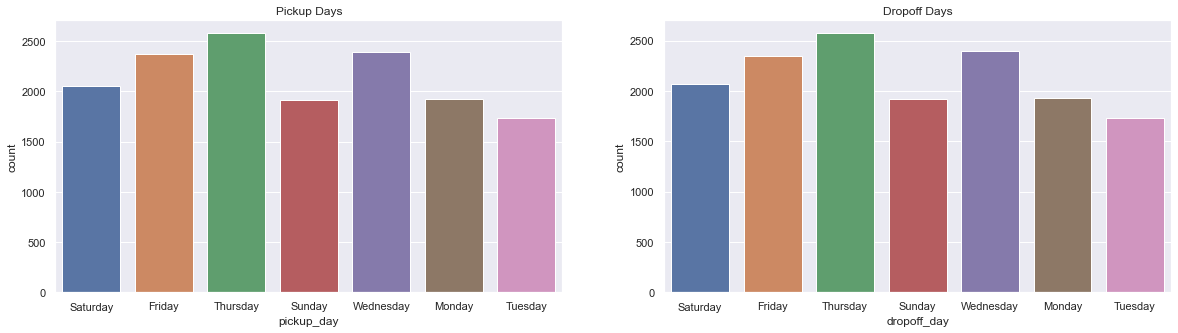

In [37]:
figure,(ax1,ax2)=plt.subplots(ncols=2,figsize=(20,5))
ax1.set_title('Pickup Days')
ax=sns.countplot(x="pickup_day",data=sample.compute(),ax=ax1)

ax2.set_title('Dropoff Days')
ax=sns.countplot(x="dropoff_day",data=sample.compute(),ax=ax2)

 We see thursday is the busiest day

In [38]:
sample.groupby('pickup_day').mean().compute()[['passenger_count','fare_amount','tip_amount','duration']].style.highlight_max(color='lightblue').highlight_min(color='pink')

,passenger_count,fare_amount,tip_amount,duration
pickup_day,,,,
Friday,1.745462,12.420688,1.469515,806.267623
Saturday,1.734405,11.145468,1.235044,667.189571
Sunday,1.805120,12.072502,1.277273,680.481191
Thursday,1.730978,12.003556,1.513909,785.846273
Monday,1.651744,11.934409,1.559854,716.369599
Tuesday,1.572743,12.592869,1.582996,840.546291
Wednesday,1.723013,12.303138,1.483105,764.248117


#### Pickup Day Fare Amount

[Text(0.5, 1.0, 'Fare amount frequency for piyckup day')]

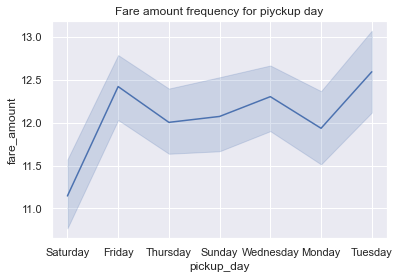

In [39]:
##fare_amount per day
p=sns.lineplot(x='pickup_day',y='fare_amount',data=sample)
p.set(title="Fare amount frequency for piyckup day")

As we see Thursday's are highest paid rides and sunday's are low fair rates may becasuse of holiday people want to take rest.

#### pickup_hour and dropoff_hour with an hour of the day in the 24-hour format.

In [40]:
sample['pickup_hour']=sample['pickup_datetime'].dt.hour
sample['dropoff_hour']=sample['dropoff_datetime'].dt.hour

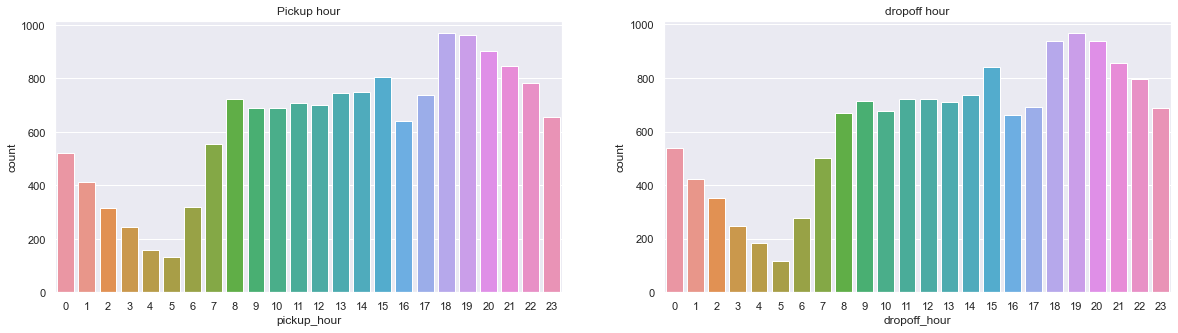

In [41]:
figure,(ax1,ax2)=plt.subplots(ncols=2,figsize=(20,5))
ax1.set_title('Pickup hour')
ax=sns.countplot(x="pickup_hour",data=sample.compute(),ax=ax1)

ax2.set_title('dropoff hour')
ax=sns.countplot(x="dropoff_hour",data=sample.compute(),ax=ax2)

We see the busiest hours are 6:00 pm to 7:00 pm and that makes sense as this is the time when people return from their offices.

In [42]:
sample.groupby('pickup_hour').mean().compute()[['passenger_count','fare_amount','tip_amount','duration']].style.highlight_max(color='lightblue').highlight_min(color='pink')

,passenger_count,fare_amount,tip_amount,duration
pickup_hour,,,,
0,1.825670,13.068008,1.601609,708.647510
1,1.746959,11.911192,1.465255,658.785888
2,1.791798,11.561514,1.201262,614.640379
3,1.881633,12.691837,1.390857,658.326531
4,1.702532,14.066456,1.354873,673.348101
5,1.393939,15.049242,2.137045,666.939394
6,1.595611,11.959248,1.415580,607.705329
7,1.641953,11.638336,1.368047,716.641953
8,1.601660,11.910097,1.553416,813.432918


#### Fare amount for hour

[Text(0.5, 1.0, 'Fare amount frequency for piyckup hour')]

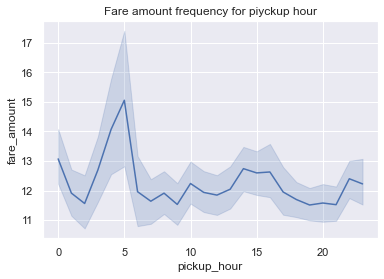

In [43]:
##fare_amount per hour
p=sns.lineplot(x='pickup_hour',y='fare_amount',data=sample)
p.set(title="Fare amount frequency for piyckup hour")

As we see 5pm   the highest fair amount paid by passengers.

#### pickup_month and dropoff_month with month number with January=1 and December=12.

In [44]:
sample['pickup_month']=sample['pickup_datetime'].dt.month
sample['dropoff_month']=sample['dropoff_datetime'].dt.month

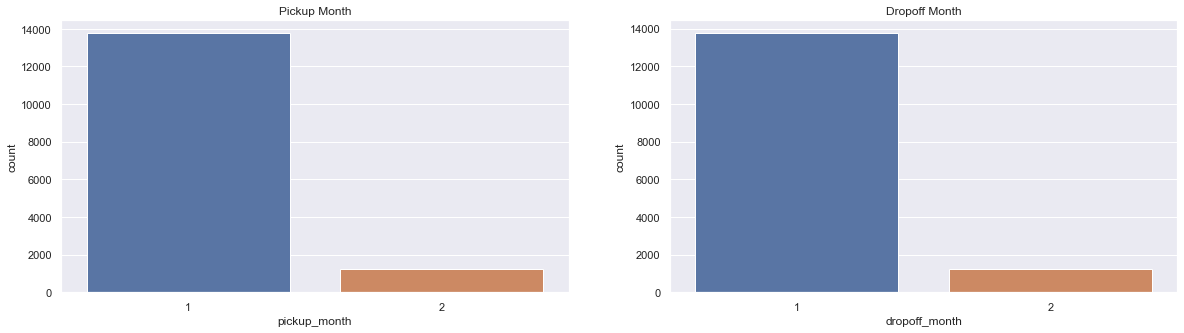

In [45]:
figure,(ax1,ax2)=plt.subplots(ncols=2,figsize=(20,5))
ax1.set_title('Pickup Month')
ax=sns.countplot(x="pickup_month",data=sample.compute(),ax=ax1)

ax2.set_title('Dropoff Month')
ax=sns.countplot(x="dropoff_month",data=sample.compute(),ax=ax2)



In January month  most rides taken 

#### pickup_month fare amount

[Text(0.5, 1.0, 'Fare amount frequency for piyckup month')]

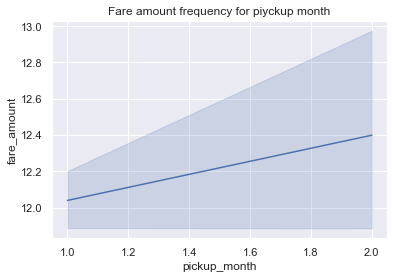

In [46]:
##fare_amount by month
p=sns.lineplot(x='pickup_month',y='fare_amount',data=sample)
p.set(title="Fare amount frequency for piyckup month")

#### Time of day

I have defined a function that lets us determine what time of the day the ride was taken. I have created 4 time zones ‘Morning’ (from 6:00 am to 11:59 pm), ‘Afternoon’ (from 12 noon to 3:59 pm), ‘Evening’ (from 4:00 pm to 9:59 pm), and ‘Late Night’ (from 10:00 pm to 5:59 am)

In [47]:
def time_of_day(x):
    if x in range(6,12):
        return 'Morning'
    elif x in range(12,16):
        return 'Afternoon'
    elif x in range(16,22):
        return 'Evening'
    else:
        return 'Late night'

In [48]:
sample['pickup_timeofday']=sample['pickup_hour'].apply(time_of_day)
sample['dropoff_timeofday']=sample['dropoff_hour'].apply(time_of_day)

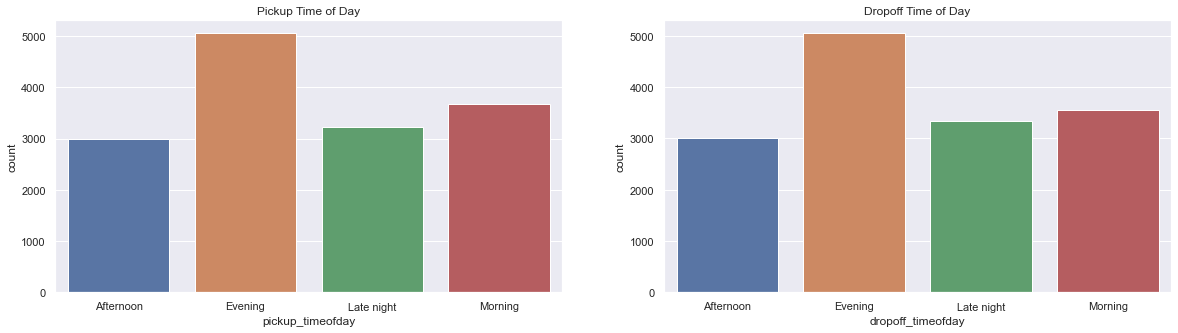

In [49]:
figure,(ax3,ax4)=plt.subplots(ncols=2,figsize=(20,5))
ax3.set_title('Pickup Time of Day')
ax=sns.countplot(x="pickup_timeofday",data=sample.compute(),ax=ax3)
ax4.set_title('Dropoff Time of Day')
ax=sns.countplot(x="dropoff_timeofday",data=sample.compute(),ax=ax4)

As we saw above, evenings are the busiest

In [50]:
sample.groupby('pickup_timeofday').mean().compute()[['passenger_count','fare_amount','tip_amount','duration']].style.highlight_max(color='lightblue').highlight_min(color='pink')

,passenger_count,fare_amount,tip_amount,duration
pickup_timeofday,,,,
Afternoon,1.720667,12.318626,1.370260,813.415667
Evening,1.717366,11.765162,1.457900,746.771163
Late night,1.771429,12.539286,1.528177,683.639130
Morning,1.651289,11.868521,1.425075,774.239077


#### Time of day with fare amount

[Text(0.5, 1.0, 'Fare amount frequency for piyckup time of day')]

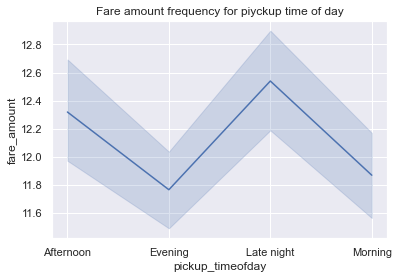

In [51]:
##fare_amount by time of day
p=sns.lineplot(x='pickup_timeofday',y='fare_amount',data=sample)
p.set(title="Fare amount frequency for piyckup time of day")

As we see late night the fair amount  is more.

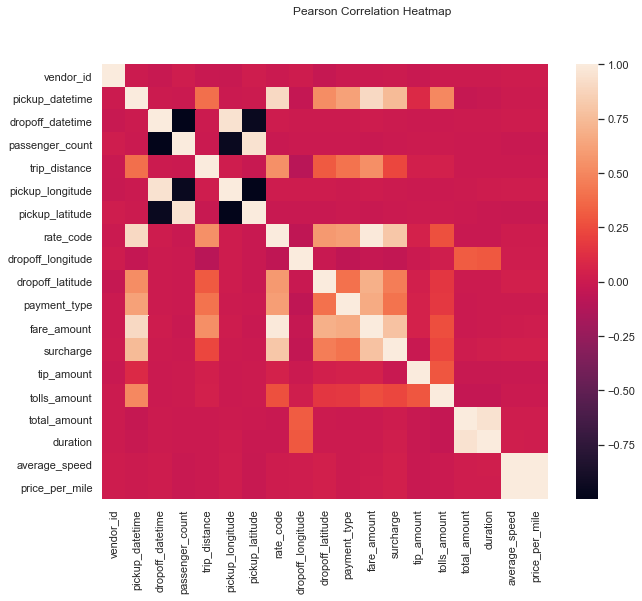

In [52]:
 
plt.figure(figsize=(10, 8))
sns.heatmap(sample.corr(),xticklabels=sample.columns[:-8],yticklabels=sample.columns[:-8])
plt.suptitle('Pearson Correlation Heatmap')
plt.show();

#### Type of payment by passenger

[Text(0.5, 1.0, 'passenger count by type of payment')]

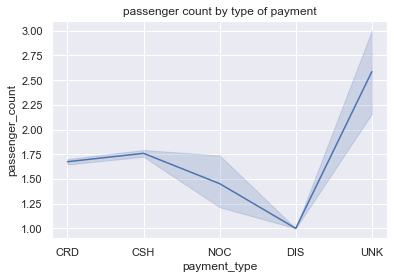

In [53]:
##fare_amount per hour
p=sns.lineplot(x='payment_type',y='passenger_count',data=sample)
p.set(title="passenger count by type of payment")


#### Passenger count

[Text(0.5, 1.0, 'passenger frequency')]

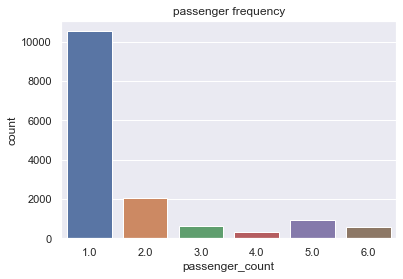

In [54]:
p=sns.countplot(x='passenger_count',data=sample.compute())
p.set(title="passenger frequency")

Most rides taken by the single passenger

In [55]:
sample.groupby('passenger_count').mean().compute()[['fare_amount','tip_amount','duration']].style.highlight_max(color='lightblue').highlight_min(color='pink')

,fare_amount,tip_amount,duration
passenger_count,,,
1.0,11.975597,1.469499,746.922317
2.0,12.730769,1.519990,783.452719
3.0,11.992512,1.234809,752.367720
4.0,11.785246,1.138066,782.990164
6.0,11.856649,1.419430,750.089810
5.0,11.932597,1.289337,752.381215


Tip amount and duration of travel show upward trend with increasing number of passengers. 

In [56]:
#Fare amount mean and standard deviation:
fare_amount_mean = sample["fare_amount"].mean()
#fare_amount_standard_deviation = math.sqrt(((sample["fare_amount"] - fare_amount_mean) ** 2).mean())
fare_amount_standard_deviation=sample["fare_amount"].std()

print("average fair amount (mean) : ${0:.2f}".format(fare_amount_mean.compute()))
print("fare amount standard deviation : ${0:.2f}\n".format(fare_amount_standard_deviation.compute()))

average fair amount (mean) : $12.07
fare amount standard deviation : $9.79



#### Check the taxi’s fair amount requency by  using Histogram.

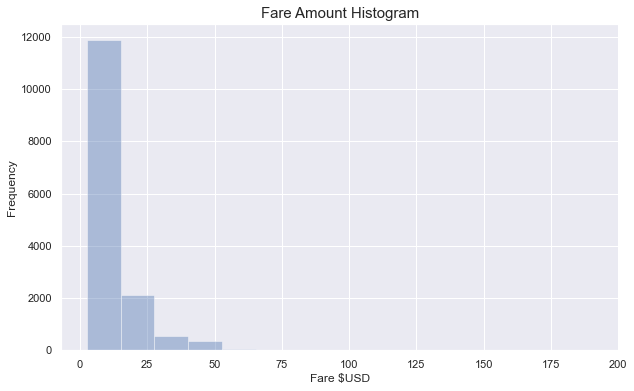

In [57]:
# plot histogram of fare
plt.figure(figsize=(10,6))
sns.set(color_codes=True)
ax = sns.distplot(sample.fare_amount, bins=15, kde=False)
plt.xlabel('Fare $USD')
plt.ylabel('Frequency')

    
plt.title('Fare Amount Histogram', fontsize=15)
plt.show()

It shows up, greater part of taxi ride charges are between five to 15 dollars.

#### Importing the library which lets us calculate distance from geographical coordinates.
from geopy.distance import great_circle


In [58]:
sample.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,...,average_speed,price_per_mile,pickup_day,dropoff_day,pickup_hour,dropoff_hour,pickup_month,dropoff_month,pickup_timeofday,dropoff_timeofday
222732,CMT,2014-01-11 14:01:02,2014-01-11 14:21:44,1.0,9.8,-73.981636,40.732601,1,-73.937843,40.841061,...,28.406,0.34,Saturday,Saturday,14,14,1,1,Afternoon,Afternoon
142525,CMT,2014-01-10 21:31:10,2014-01-10 21:48:06,1.0,3.3,-74.008369,40.721024,1,-73.976929,40.747944,...,11.693,0.24,Friday,Friday,21,21,1,1,Evening,Evening
248097,CMT,2014-01-11 19:11:32,2014-01-11 19:24:41,1.0,3.9,-73.980965,40.729435,1,-73.963356,40.774635,...,17.795,0.29,Saturday,Saturday,19,19,1,1,Evening,Evening
128150,CMT,2014-01-10 16:28:20,2014-01-10 16:31:12,1.0,0.6,-73.945267,40.774349,1,-73.947693,40.780437,...,12.558,0.13,Friday,Friday,16,16,1,1,Evening,Evening
210256,CMT,2014-01-11 03:17:27,2014-01-11 03:28:58,2.0,2.9,-73.987183,40.729458,1,-74.016129,40.711262,...,15.109,0.25,Saturday,Saturday,3,3,1,1,Late night,Late night


#### Distance and Vendor

Text(0.5, 1.0, 'distance frequency by vender id')

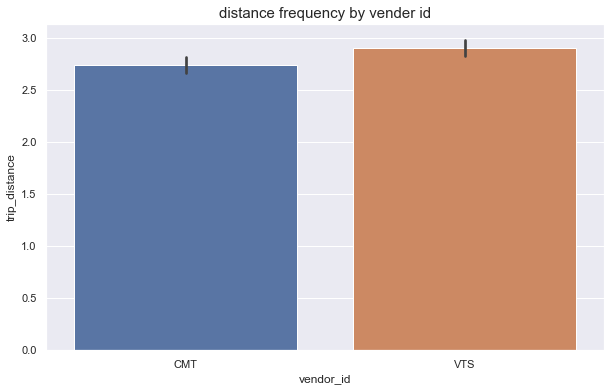

In [59]:
plt.figure(figsize=(10,6))
p=sns.barplot(y='trip_distance',x='vendor_id',data=sample.compute(),estimator=np.mean)
plt.title("distance frequency by vender id", fontsize=15)

The distribution for both vendors is very similar.

dask.dataframe.core.DataFrame

In [63]:
sample.groupby('vendor_id').mean()[['passenger_count','fare_amount','tip_amount','duration','trip_distance']].compute().style.highlight_max(color='lightblue').highlight_min(color='pink')

,passenger_count,fare_amount,tip_amount,duration,trip_distance
vendor_id,,,,,
CMT,1.258677,11.842680,1.459211,743.805721,2.740171
VTS,2.155570,12.287532,1.435848,762.557680,2.909495


#### Distance per passenger count

<Figure size 720x432 with 0 Axes>

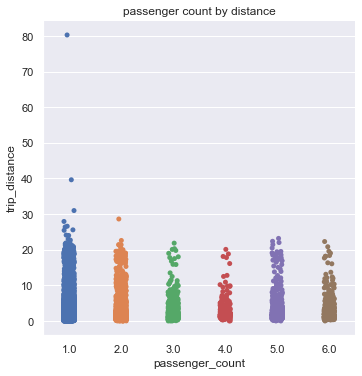

In [64]:
plt.figure(figsize=(10,6))
p=sns.catplot(y='trip_distance',x='passenger_count',data=sample.compute(),kind="strip")
p.set(title="passenger count by distance")

We see some of the longer distances are covered by either 1 or 3 or 5 passenger rides.

#### Distance per day of week

[Text(0.5, 1.0, 'distance frequency for pickup day')]

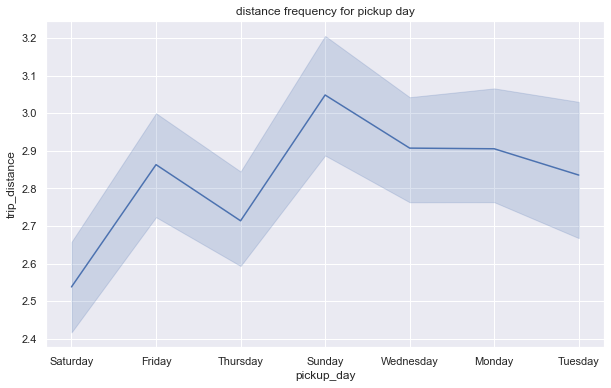

In [65]:
plt.figure(figsize=(10,6))
p=sns.lineplot(x='pickup_day',y='trip_distance',data=sample)
p.set(title="distance frequency for pickup day")

- Distances are longer on Sundays probably because it’s weekend.
- Monday trip distances are also quite high.


#### Distance per hour of day

[Text(0.5, 1.0, 'distance frequency for pickup hour')]

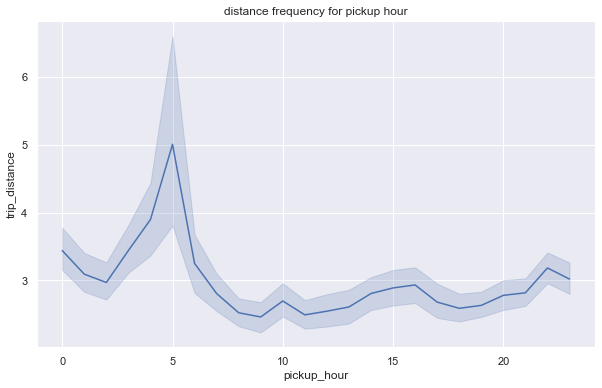

In [66]:
plt.figure(figsize=(10,6))
p=sns.lineplot(x='pickup_hour',y='trip_distance',data=sample)
p.set(title="distance frequency for pickup hour")

Distances are the longest around 4 am.

#### Distance per time of day

[Text(0.5, 1.0, 'distance frequency for pickup time of day')]

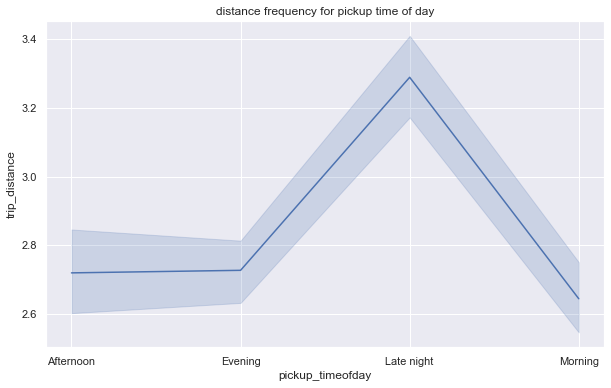

In [67]:
plt.figure(figsize=(10,6))
p=sns.lineplot(x='pickup_timeofday',y='trip_distance',data=sample)
p.set(title="distance frequency for pickup time of day")

As seen above also, distances being the longest during late night or it maybe called as early morning too.

This can probably point to outstation trips where people start early for the day.

#### Distance per month

[Text(0.5, 1.0, 'distance frequency for pickup month')]

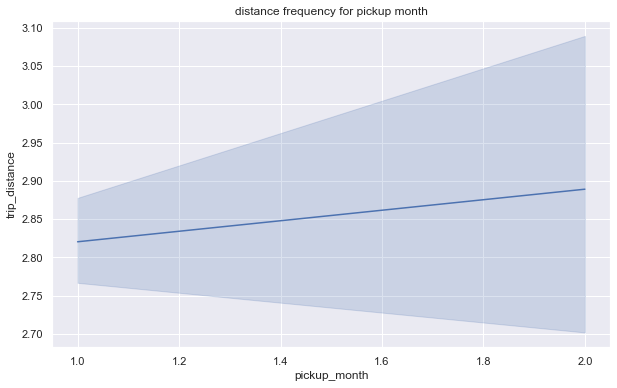

In [68]:
plt.figure(figsize=(10,6))
p=sns.lineplot(x='pickup_month',y='trip_distance',data=sample)
p.set(title="distance frequency for pickup month")

As we also saw during trip duration per month, similarly trip distance is same beacuse here my datails using only two months

#### price_per_mile by pickup day

[Text(0.5, 1.0, 'fare per mile for pickup day')]

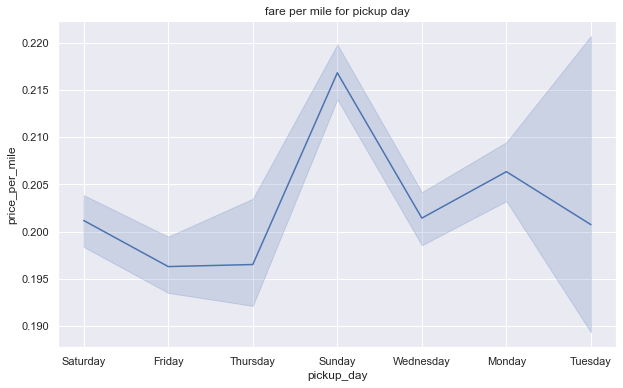

In [69]:
plt.figure(figsize=(10,6))
p= sns.lineplot(x='pickup_day',y='price_per_mile',data=sample)
p.set(title="fare per mile for pickup day")


As we saw fridays are higher rate for mile

[Text(0.5, 1.0, 'fare per mile for pickup hour')]

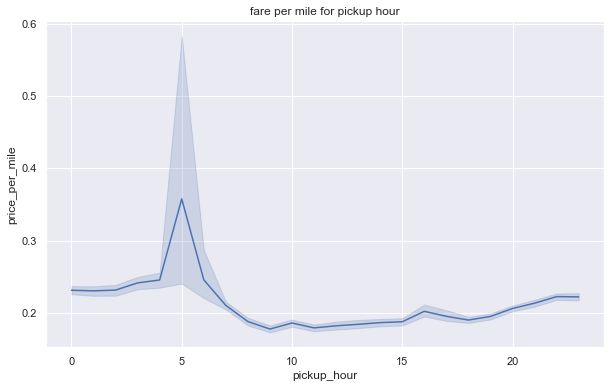

In [70]:
plt.figure(figsize=(10,6))
p=sns.lineplot(x='pickup_hour',y='price_per_mile',data=sample)
p.set(title="fare per mile for pickup hour")


As we saw 3 am and 6am are peak hours paying by highest per mile

[Text(0.5, 1.0, 'fare per mile for pickup time of day')]

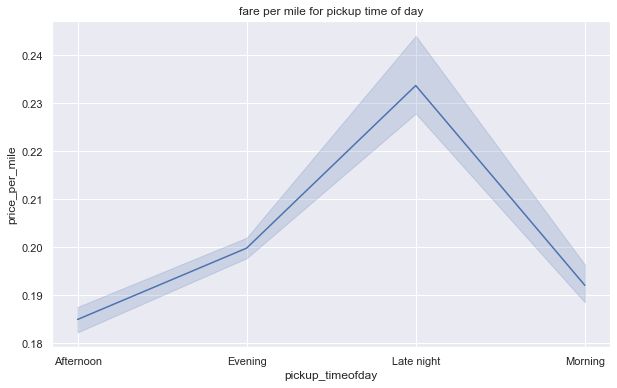

In [71]:
plt.figure(figsize=(10,6))
p=sns.lineplot(x='pickup_timeofday',y='price_per_mile',data=sample)
p.set(title="fare per mile for pickup time of day")

Latenight times are highest rate per mile

#### Passenger Count and Vendor id

[Text(0.5, 1.0, 'vendor_id shared by passenger')]

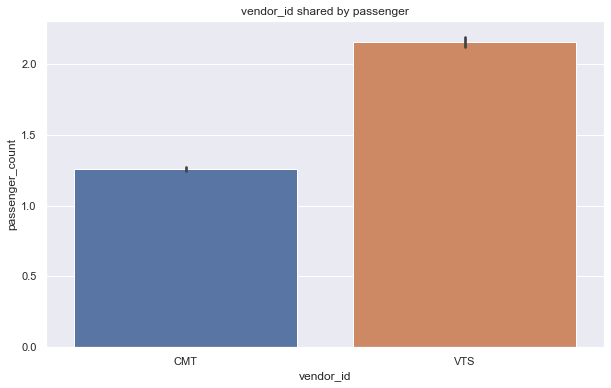

In [72]:
plt.figure(figsize=(10,6))
p=sns.barplot(y='passenger_count',x='vendor_id',data=sample.compute())
p.set(title="vendor_id shared by passenger")

This shows that vendor VTS generally carries more passengers than vendor CMT  passenger rides.

#### Relationship between fareamount and tip amount 

[Text(0.5, 1.0, 'tip amount accodring to fare amount')]

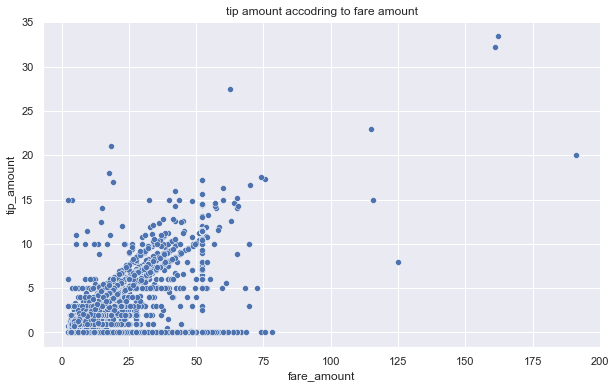

In [73]:
#p=sns.lineplot(y='tip_amount',x='fare_amount',data=sample)
plt.figure(figsize=(10,6))
p=sns.scatterplot(x="fare_amount", y="tip_amount", data=sample);
p.set(title="tip amount accodring to fare amount")

#### Relationship between tip amount and passenger

<Figure size 720x432 with 0 Axes>

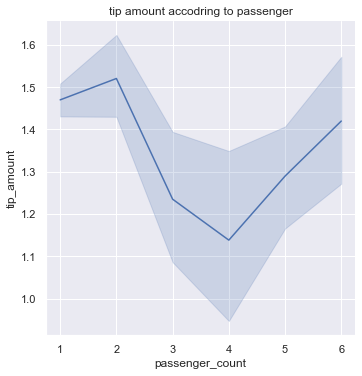

In [74]:
plt.figure(figsize=(10,6))
p=sns.relplot( x="passenger_count",y="tip_amount", kind="line", data=sample);
p.set(title="tip amount accodring to passenger")

In [75]:
sample.columns

Index(['vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'trip_distance', 'pickup_longitude', 'pickup_latitude', 'rate_code',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'surcharge', 'tip_amount', 'tolls_amount', 'total_amount', 'duration',
       'average_speed', 'price_per_mile', 'pickup_day', 'dropoff_day',
       'pickup_hour', 'dropoff_hour', 'pickup_month', 'dropoff_month',
       'pickup_timeofday', 'dropoff_timeofday'],
      dtype='object')

[Text(0.5, 1.0, 'fare per mile for pickup time of day')]

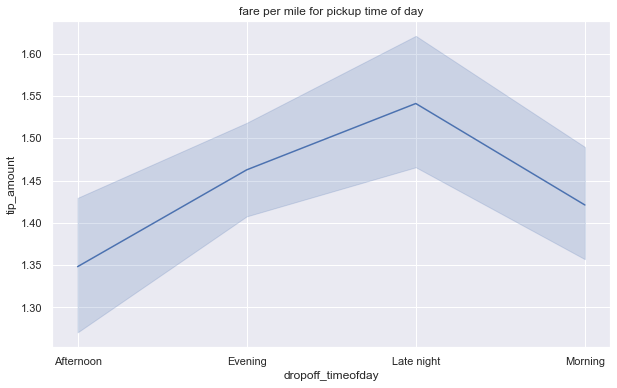

In [76]:
plt.figure(figsize=(10,6))
p=sns.lineplot(x='dropoff_timeofday',y='tip_amount',data=sample)
p.set(title="fare per mile for pickup time of day")

- High tip amount is often provided during late night.
- Morming ad evening hours show almost same trend in tip amount. 
- Afternoon tip amount is the least.

#### Relationshipb between Distance and tipamount

[Text(0.5, 1.0, 'tip amount according to distance')]

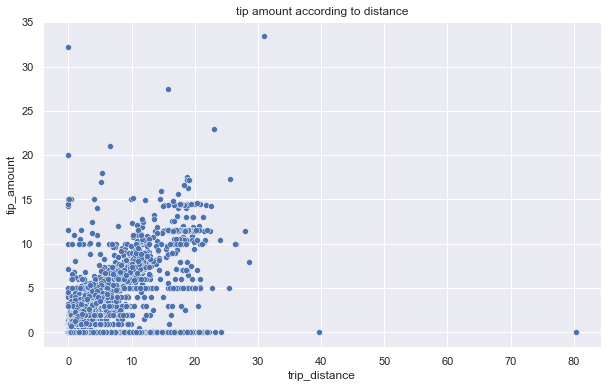

In [77]:
plt.figure(figsize=(10,6))
p=sns.scatterplot( x="trip_distance",y="tip_amount", data=sample);
p.set(title="tip amount according to distance")

- Higher trip distance does not yield to higher tip amount

In [78]:
#sns.catplot(y='distance',x='fare_amount',data=sample.compute(),kind="strip");

In [79]:
sample.columns[:-8]

Index(['vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'trip_distance', 'pickup_longitude', 'pickup_latitude', 'rate_code',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'surcharge', 'tip_amount', 'tolls_amount', 'total_amount', 'duration',
       'average_speed', 'price_per_mile'],
      dtype='object')

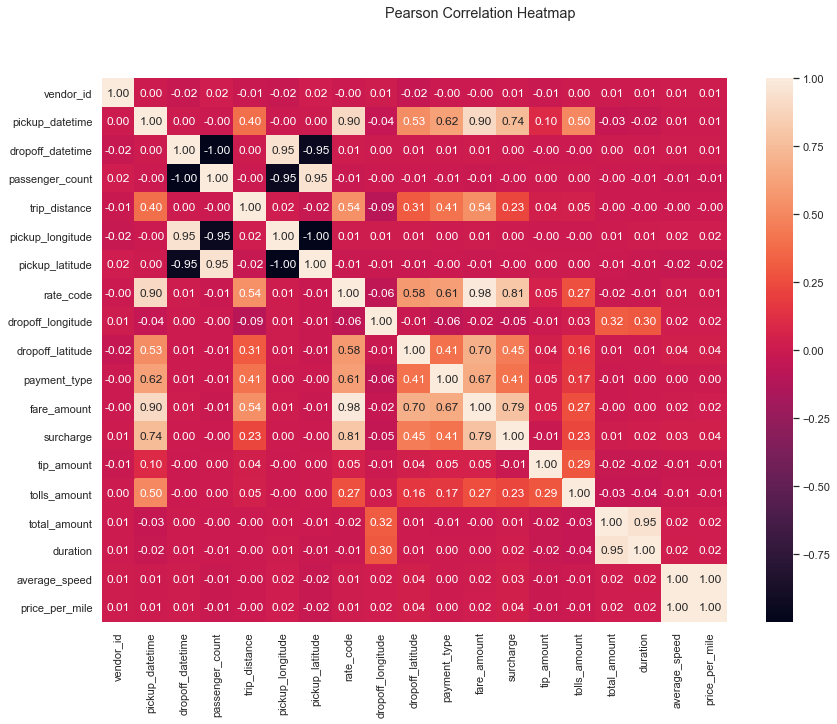

In [80]:
# get rid fro now !! 
plt.figure(figsize=(14, 10))
sns.heatmap(sample.corr(),xticklabels=sample.columns[:-8],yticklabels=sample.columns[:-8],annot=True,fmt='.2f')
plt.suptitle('Pearson Correlation Heatmap')
plt.show();

### Maps

In [81]:
pickup_locations = sample[["pickup_latitude", "pickup_longitude", "pickup_day","pickup_timeofday","dropoff_latitude", "dropoff_longitude", "dropoff_day","dropoff_timeofday"]].compute()
pickup_location_sample = pickup_locations.sample(frac=0.001)

In [92]:
map1 = folium.Map(location=[40.715271,-74.009209], zoom_start=12)

In [96]:
coordinates = []
for i in range(len(pickup_location_sample)):
    coordinates.append(
        [[pickup_location_sample.iloc[i].pickup_latitude, pickup_location_sample.iloc[i].pickup_longitude],
        [pickup_location_sample.iloc[i].dropoff_latitude,pickup_location_sample.iloc[i].dropoff_longitude]]
        )

folium.PolyLine(coordinates, line_color='#FF0000', line_weight=5).add_to(map1)

for index, location_info in pickup_location_sample.iterrows():
    folium.Marker([location_info["pickup_latitude"], location_info["pickup_longitude"]], popup=location_info[["pickup_day","pickup_timeofday"]],icon=folium.Icon(color='red')).add_to(map1)
for index, location_info in pickup_location_sample.iterrows():
    folium.Marker([location_info["dropoff_latitude"], location_info["dropoff_longitude"]], popup=location_info[["dropoff_day","dropoff_timeofday"]],icon=folium.Icon(color='blue')).add_to(map1)

map1

In [85]:
pickup_location_sample1 = pickup_locations.sample(frac=0.01)

In [91]:
#create a map
this_map = folium.Map(location=[40.715271,-74.009209], zoom_start=12)

# List comprehension to make out list of lists
heat_data = [[row['pickup_latitude'],row['pickup_longitude']] for index, row in pickup_location_sample1.iterrows()]

# Plot it on the map
HeatMap(heat_data,
             color='blue',
             fill_color='#FD8A6C').add_to(this_map)


#Set the zoom to the maximum possible
#this_map.fit_bounds(this_map.get_bounds())
    
this_map  

In [90]:
#create a map
this_map1 = folium.Map(location=[40.715271,-74.009209], zoom_start=12)

# List comprehension to make out list of lists
heat_data = [[row['dropoff_latitude'],row['dropoff_longitude']] for index, row in pickup_location_sample1.iterrows()]

# Plot it on the map
HeatMap(heat_data,
             color='red',
             fill_color='#FD8A6C').add_to(this_map1)

#Set the zoom to the maximum possible
#this_map.fit_bounds(this_map.get_bounds())
    
this_map1  

location analysis based on fare and tip amount 

In [88]:
df_=sample[["tip_amount","pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude","trip_distance","fare_amount"]].compute().nlargest(20,["tip_amount","fare_amount"])
type(df_)
df_


,tip_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_distance,fare_amount
136918,33.45,-73.867798,40.770851,-73.704124,41.068977,31.00,162.000000
241450,32.20,-74.035217,40.718948,-74.035217,40.718948,0.00,161.000000
246071,27.50,-74.014648,40.709576,-74.177589,40.690556,15.70,62.500000
177648,23.00,-73.964592,40.767002,-73.627960,40.800991,23.00,115.000000
28742,21.00,-73.949959,40.741550,-73.870430,40.773598,6.60,18.500000
185163,20.00,0.000000,0.000000,0.000000,0.000000,0.00,191.000000
234671,18.00,-73.941811,40.798466,-73.936859,40.754791,5.36,17.500000
93219,17.49,-73.979141,40.776978,-74.177765,40.695480,18.73,74.000000
150504,17.30,-73.990837,40.740002,-74.171852,40.919010,25.58,75.500000
109366,17.20,-73.781754,40.644840,-74.006462,40.744492,18.74,52.000000


In [89]:
coordinates = []
for i in range(len(df_)):
    coordinates.append(
        [[df_.iloc[i].pickup_latitude, df_.iloc[i].pickup_longitude],
        [df_.iloc[i].dropoff_latitude,df_.iloc[i].dropoff_longitude]]
        )


m = folium.Map(location=[40.715271,-74.009209], zoom_start=12)
folium.PolyLine(coordinates, line_color='#FF0000', line_weight=5).add_to(m)

for index, location_info in df_.iterrows():
    folium.Marker([location_info["pickup_latitude"], location_info["pickup_longitude"]], popup=location_info[["tip_amount","fare_amount","trip_distance"]],icon=folium.Icon(color='green')).add_to(m)
for index, location_info in df_.iterrows():
    folium.Marker([location_info["dropoff_latitude"], location_info["dropoff_longitude"]], popup=location_info[["tip_amount","fare_amount","trip_distance"]],icon=folium.Icon(color='red')).add_to(m)

m

# Conclusion

- The day with most pickups is Thursday, Friday and Wednesday
- The hour with the most rides seems to be between 6pm and 10pm
- Sundays people tend to travel longer distances
- Journeys with one or two passengers ten to tip more
- journeys to and from the airport seem to give higher tips
- Also trip late at night tend to give higher tips
- Park Avenue, Theatre district and New york Penn Station and good locations for a taxi to be to get a customer